In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00


In [2]:
import datasets as ds

dts=ds.load_dataset('SeyedAli/Image-Arousal-Valence-continious-class-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10645 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2662 [00:00<?, ? examples/s]

In [ ]:
dts = dts.filter(lambda example: example['image'] is not None)
dts = dts.filter(lambda example: example['Arousal'] is not None)
dts = dts.filter(lambda example: example['Valence'] is not None)

Filter:   0%|          | 0/8612 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2154 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8612 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2154 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8612 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2154 [00:00<?, ? examples/s]

In [3]:
dts

DatasetDict({
    train: Dataset({
        features: ['image', 'Arousal', 'Valence'],
        num_rows: 10645
    })
    test: Dataset({
        features: ['image', 'Arousal', 'Valence'],
        num_rows: 2662
    })
})

In [4]:
from datasets import DatasetDict
from PIL import Image
from PIL import Image
import io
# Define the image resizing function
def preprocess(examples, new_size=(224, 224)):

    # Resize the image
    resized_image = examples['image'].resize(new_size)
    #Convert to RGB
    examples['image'] = resized_image.convert("RGB")

    return examples

# Apply the resizing to both 'train' and 'test' datasets
dts['train'] = dts['train'].map(preprocess)
dts['test'] = dts['test'].map(preprocess)

Map:   0%|          | 0/10645 [00:00<?, ? examples/s]

Map:   0%|          | 0/2662 [00:00<?, ? examples/s]

In [5]:
import keras
from keras import layers
# from keras import ops
import tensorflow_hub as hub
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras import Input
import numpy as np
import matplotlib.pyplot as plt

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5  # For real training
image_size = 224  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images


# Define the patch size and other parameters
image_size = 224  # Resize input images to this size
projection_dim = 64

mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
class WrappedHubLayer(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=False):
        super(WrappedHubLayer, self).__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    @tf.function
    def call(self, inputs):
        return self.hub_layer(inputs)

def create_vit_Regressor():
    inputs = keras.Input(shape=(224, 224, 3))  # Define the input shape directly
    # Load a pretrained Vision Transformer from TensorFlow Hub and freeze its weights
    vit_model = WrappedHubLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False)
    representation = vit_model(inputs)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Changed the output to 1 for regresion and potentially add a linear activation
    valence_dense1= layers.Dense(128, activation='relu')(features)
    valence_dense2= layers.Dense(64, activation='relu')(valence_dense1)
    valence_logits = layers.Dense(1, activation='linear',name='Valence')(valence_dense2)
    Arousal_dense1= layers.Dense(128, activation='relu')(features)
    Arousal_dense2= layers.Dense(64, activation='relu')(Arousal_dense1)
    Arousal_logits = layers.Dense(1, activation='linear',name='Arousal')(Arousal_dense2)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=[valence_logits,Arousal_logits])
    return model

In [6]:
optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
model=create_vit_Regressor()
model.compile(optimizer=optimizer,
              loss={
                  'Arousal': 'mean_squared_error',
                  'Valence': 'mean_squared_error'},
              metrics={
                  'Arousal': 'mean_absolute_error',
                  'Valence': 'mean_absolute_error'})

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 wrapped_hub_layer (Wrapped  (None, 768)                  8579865   ['input_1[0][0]']             
 HubLayer)                                                6                                       
                                                                                                  
 dense (Dense)               (None, 2048)                 1574912   ['wrapped_hub_layer[0][0]']   
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['dense[0][0]']           

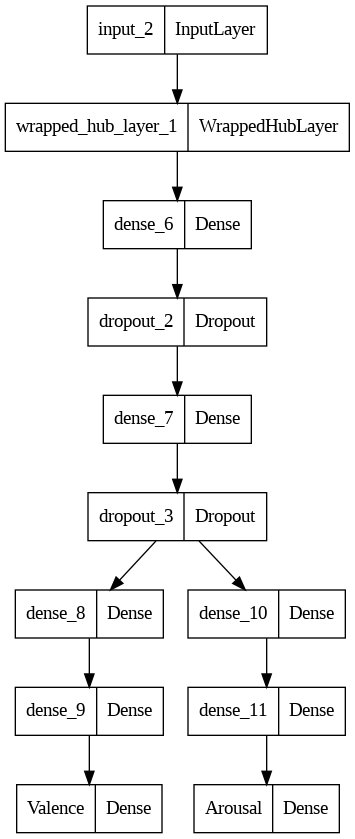

In [8]:
import keras
keras.utils.plot_model(create_vit_Regressor(),to_file="model.png")

In [9]:
tf_train_ds = dts['train'].to_tf_dataset(
            columns=["image"],
            label_cols=["Valence","Arousal"],
            batch_size=2,
            shuffle=True
            )
tf_test_ds = dts['test'].to_tf_dataset(
            columns=["image"],
            label_cols=["Valence","Arousal"],
            batch_size=2,
            shuffle=True
            )

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [10]:
checkpoint_filepath = "checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
)
history = model.fit(
        tf_train_ds,
        validation_data=tf_test_ds,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

Epoch 1/5
5323/5323 [==============================] - 270s 48ms/step - loss: 1.8457 - Valence_loss: 1.0820 - Arousal_loss: 0.7637 - Valence_mean_absolute_error: 0.8132 - Arousal_mean_absolute_error: 0.6762 - val_loss: 0.9672 - val_Valence_loss: 0.5935 - val_Arousal_loss: 0.3738 - val_Valence_mean_absolute_error: 0.5972 - val_Arousal_mean_absolute_error: 0.4989
Epoch 2/5
5323/5323 [==============================] - 255s 48ms/step - loss: 1.2396 - Valence_loss: 0.7487 - Arousal_loss: 0.4909 - Valence_mean_absolute_error: 0.6988 - Arousal_mean_absolute_error: 0.5643 - val_loss: 0.9396 - val_Valence_loss: 0.5411 - val_Arousal_loss: 0.3985 - val_Valence_mean_absolute_error: 0.6167 - val_Arousal_mean_absolute_error: 0.5050
Epoch 3/5
5323/5323 [==============================] - 255s 48ms/step - loss: 1.0431 - Valence_loss: 0.6169 - Arousal_loss: 0.4262 - Valence_mean_absolute_error: 0.6422 - Arousal_mean_absolute_error: 0.5252 - val_loss: 0.9729 - val_Valence_loss: 0.5504 - val_Arousal_loss:

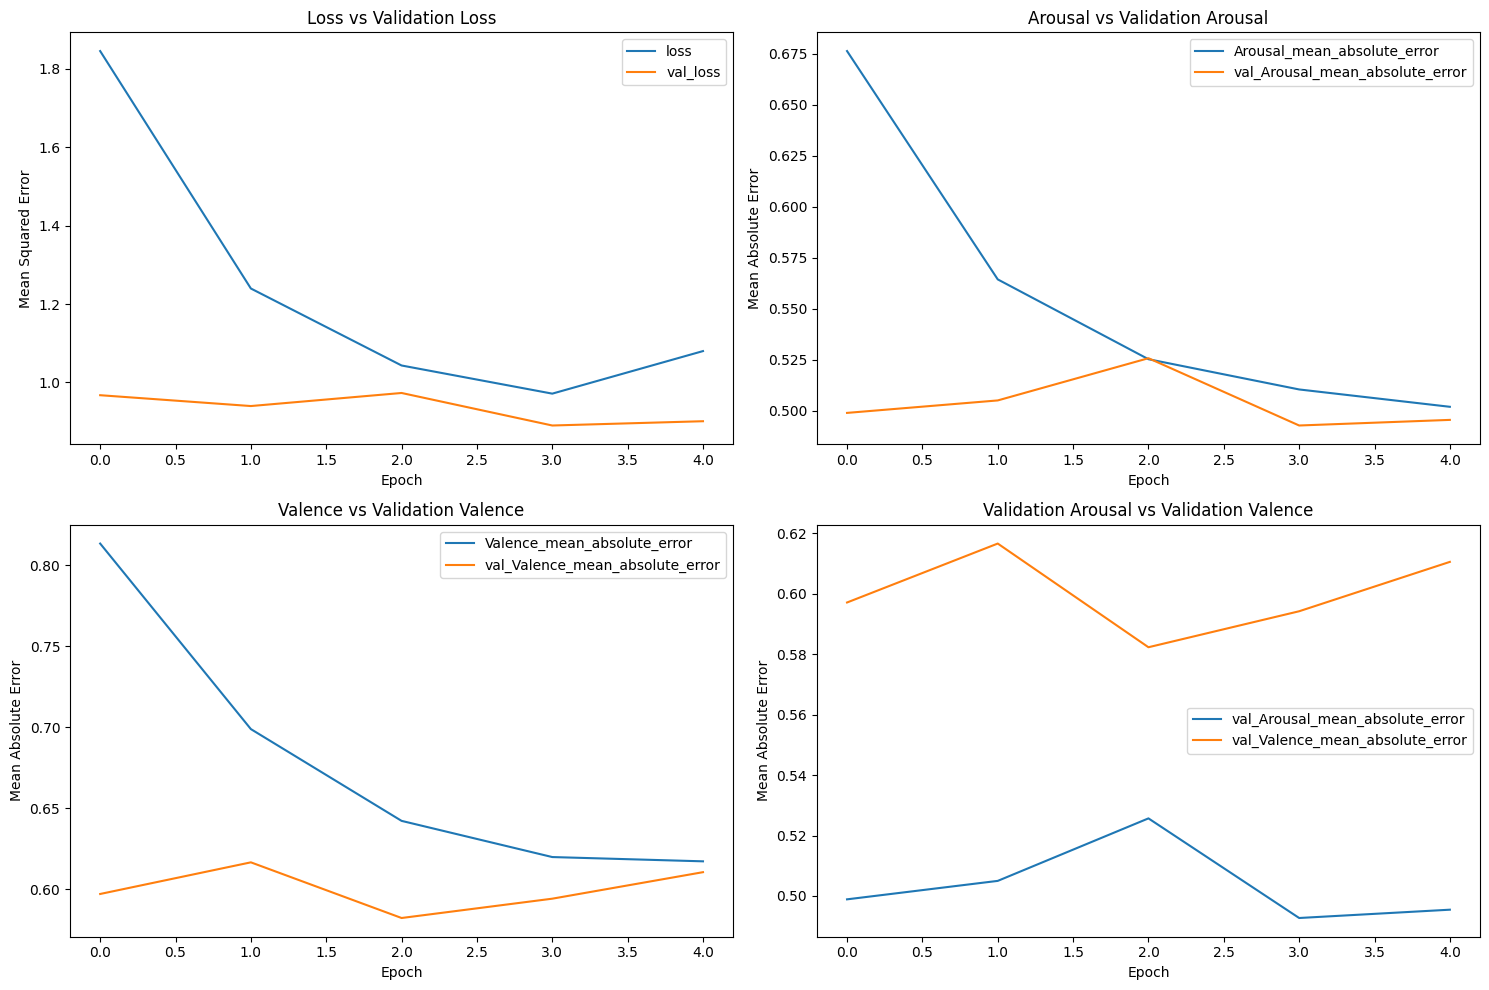

In [11]:
import matplotlib.pyplot as plt
# Create a figure with 2x3 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axs[0, 0].plot(history.history['loss'], label='loss')
axs[0, 0].plot(history.history['val_loss'], label='val_loss')
axs[0, 0].set_title('Loss vs Validation Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Mean Squared Error')
axs[0, 0].legend()

# Arousal Output Loss plot
axs[0, 1].plot(history.history['Arousal_mean_absolute_error'], label='Arousal_mean_absolute_error')
axs[0, 1].plot(history.history['val_Arousal_mean_absolute_error'], label='val_Arousal_mean_absolute_error')
axs[0, 1].set_title('Arousal vs Validation Arousal')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Mean Absolute Error')
axs[0, 1].legend()

# Valence Output Accuracy plot
axs[1, 0].plot(history.history['Valence_mean_absolute_error'], label='Valence_mean_absolute_error')
axs[1, 0].plot(history.history['val_Valence_mean_absolute_error'], label='val_Valence_mean_absolute_error')
axs[1, 0].set_title('Valence vs Validation Valence')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Mean Absolute Error')
axs[1, 0].legend()

# val_Arousal and val_Valence Output plot
axs[1, 1].plot(history.history['val_Arousal_mean_absolute_error'], label='val_Arousal_mean_absolute_error')
axs[1, 1].plot(history.history['val_Valence_mean_absolute_error'], label='val_Valence_mean_absolute_error')
axs[1, 1].set_title('Validation Arousal vs Validation Valence')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Mean Absolute Error')
axs[1, 1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [12]:
model.save('keras_Regression_13307')

In [ ]:
!zip -r 'keras_Regression_13307.zip' 'keras_Regression_13307'

  adding: keras_Regression_13307/ (stored 0%)
  adding: keras_Regression_13307/keras_metadata.pb (deflated 91%)
  adding: keras_Regression_13307/variables/ (stored 0%)
  adding: keras_Regression_13307/variables/variables.index (deflated 75%)
  adding: keras_Regression_13307/variables/variables.data-00000-of-00001

In [ ]:
!unzip '/content/drive/MyDrive/keras_Regression_13307.zip'

Archive:  /content/drive/MyDrive/keras_Regression_13307.zip
   creating: keras_Regression_13307/
  inflating: keras_Regression_13307/keras_metadata.pb  
   creating: keras_Regression_13307/variables/
  inflating: keras_Regression_13307/variables/variables.index  
  inflating: keras_Regression_13307/variables/variables.data-00000-of-00001  
 extracting: keras_Regression_13307/fingerprint.pb  
   creating: keras_Regression_13307/assets/
  inflating: keras_Regression_13307/saved_model.pb  


In [ ]:
from keras.models import load_model

model=load_model('/content/keras_Regression_13307')

In [13]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    # Open the image file
    img = Image.open(image_path)

    # Resize the image to 224x224
    img = img.resize((224, 224))

    # Convert the image to a numpy array
    img_array = np.array(img)

    # Expand dimensions to match the input shape expected by Keras models (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [14]:
model.predict(preprocess_image('/content/example1.jpg'))

1/1 [==============================] - 4s 4s/step


[array([[2.9867558]], dtype=float32), array([[2.6161435]], dtype=float32)]

In [15]:
model.predict(preprocess_image('example1.jpg'))[0][0][0]

1/1 [==============================] - 0s 91ms/step


2.9867558

In [16]:
model.predict(preprocess_image('/content/oxford-street-solus-feature-FINAL-1.jpg'))

1/1 [==============================] - 0s 23ms/step


[array([[3.056085]], dtype=float32), array([[2.7246928]], dtype=float32)]

In [17]:
model.predict(preprocess_image('/content/1524365186408267780.jpg'))

1/1 [==============================] - 0s 21ms/step


[array([[2.9950051]], dtype=float32), array([[2.6930852]], dtype=float32)]

In [ ]:
model.predict(preprocess_image('/content/dokhtar-chadori.jpg'))

1/1 [==============================] - 1s 766ms/step


[array([[3.0939097]], dtype=float32), array([[2.7244754]], dtype=float32)]

In [ ]:
!unzip '/content/drive/MyDrive/cgna.zip'

In [ ]:
import pandas as pd
df=pd.read_excel('data.xlsx')
df.insert(3,'predicted_Valance',None)
df.insert(4,'predicted_Arousal',None)
df.head()

,Image,Valence,Arousal,predicted_Valance,predicted_Arousal
0,1,8.12,2.84,None,None
1,2,4.31,5.13,None,None
2,3,5.92,3.80,None,None
3,4,5.47,5.32,None,None
4,5,4.93,5.23,None,None


In [ ]:
from tqdm import tqdm
cant_predict=[]
for index,row in tqdm(df.iterrows(),total=len(df)):
  try:
    df['predicted_Valance'][index]=model.predict(preprocess_image(str(row['Image'])+'.jpg'))[0][0][0]
    df['predicted_Arousal'][index]=model.predict(preprocess_image(str(row['Image'])+'.jpg'))[1][0][0]
  except:
    cant_predict.append(row['Image'])

In [ ]:
df.head()

,Image,Valence,Arousal
0,1,8.12,2.84
1,2,4.31,5.13
2,3,5.92,3.80
3,4,5.47,5.32
4,5,4.93,5.23


In [ ]:
df.to_excel('/content/drive/MyDrive/predicted-10766.xlsx')